In [20]:
import os
import pandas as pd

def create_image_dataframe(base_dir='pictures'):
    data = []

    for country in os.listdir(base_dir):
        country_path = os.path.join(base_dir, country)
        if not os.path.isdir(country_path):
            continue

        for prompt_type in os.listdir(country_path):
            prompt_path = os.path.join(country_path, prompt_type)
            if not os.path.isdir(prompt_path):
                continue

            # Normalize prompt name: 'Prompt - China' -> 'China' or 'English'
            if 'English' in prompt_type:
                prompt = 'English'
            else:
                prompt = country  # The prompt is in the country's language

            for model in os.listdir(prompt_path):
                model_path = os.path.join(prompt_path, model)
                if not os.path.isdir(model_path):
                    continue

                for img_file in os.listdir(model_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                        image_path = os.path.join(model_path, img_file)
                        data.append({
                            'country': country,
                            'prompt': prompt,
                            'model': model,
                            'image_path': image_path
                        })

    df = pd.DataFrame(data)
    return df

In [21]:
import torch
from PIL import Image
from torchvision import transforms
import open_clip

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
def add_clip_embeddings(df, device):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    model = model.to(device)
    model.eval()

    clip_embeddings = []

    for path in df['image_path']:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(image).squeeze().cpu().numpy()
        except Exception as e:
            print(f"Error processing {path}: {e}")
            embedding = None
        clip_embeddings.append(embedding)

    df['clip'] = clip_embeddings
    return df

In [ ]:
df = pd.read_json("data_genai.json", lines=True)
df["clip"] = 

In [36]:
image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)


In [43]:
import numpy as np
import torch.nn.functional as F

def compute_country_predictions(df, device=device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Get unique country names
    countries = sorted(df['country'].unique())
    #countries.append("English")
    country_texts = [f"{c}" for c in countries]  # Add context if you like

    # Encode country names as text embeddings
    with torch.no_grad():
        tokenized = tokenizer(country_texts).to(device)

        text_features = model.encode_text(tokenized)
        text_features = F.normalize(text_features, dim=-1)  # L2-normalize

    # Convert image embeddings to tensor and normalize
    image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)

    image_features = F.normalize(image_features, dim=-1)

    # Compute cosine similarity (dot product after normalization)
    similarities = image_features @ text_features.T  # shape: [num_images, num_countries]

    # Apply softmax to get probabilities
    probs = F.softmax(similarities, dim=1).cpu().numpy()

    # Get predictions and top match
    predicted_idxs = np.argmax(probs, axis=1)
    predicted_countries = [countries[i] for i in predicted_idxs]

    # Add to dataframe
    df['predicted_country'] = predicted_countries
    df['country_correct'] = df['predicted_country'] == df['country']

    return df, probs

In [44]:
def compute_politician_prediction(df, device=device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Define class texts
    class_names = ["Photo of a politician", "Other"]
    
    # Encode the class texts
    with torch.no_grad():
        text_tokens = tokenizer(class_names).to(device)

        text_features = model.encode_text(text_tokens)
        text_features = F.normalize(text_features, dim=-1)  # shape: [2, d]

    # Prepare image features
    image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)

    image_features = F.normalize(image_features, dim=-1)

    # Compute similarity scores (dot product)
    logits = image_features @ text_features.T  # shape: [N_images, 2]

    # Apply softmax across classes
    probs = F.softmax(logits, dim=-1).cpu().numpy()

    # Get predictions
    pred_indices = np.argmax(probs, axis=1)
    predicted_labels = [class_names[i] for i in pred_indices]

    # Store results
    # df['politician_prob'] = probs[:, 0]
    # df['other_prob'] = probs[:, 1]
    df['predicted_label'] = predicted_labels
    df['politician'] = df['predicted_label'] == "Photo of a politician"

    return df

In [45]:
df, probs = compute_country_predictions(df)
df = compute_politician_prediction(df)

accuracy = df['country_correct'].mean()
print(f"Prediction accuracy: {accuracy:.2%}")

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Prediction accuracy: 76.74%


In [46]:
df[df["politician"]==False]
df[df["country_correct"]==False]

,country,prompt,model,image_path,clip,predicted_country,country_correct,predicted_label,politician
48,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese9.webp,"[-0.09965592620000001, 0.0677324086, -0.020997...",Italy,False,Photo of a politician,True
49,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese5.webp,"[-0.1031371355, 0.476937145, -0.4628292322, 0....",Netherlands,False,Photo of a politician,True
50,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese4.webp,"[-0.0474428535, -0.2118912935, -0.423160851, 0...",Netherlands,False,Photo of a politician,True
51,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese8.webp,"[-0.5394794941000001, 0.051055409, -0.43598794...",Netherlands,False,Photo of a politician,True
52,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese3.webp,"[-0.026146993, 0.4739986658, -0.36038616300000...",Netherlands,False,Photo of a politician,True
53,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese10.webp,"[-0.0032855868000000003, -0.1339292228, -0.303...",Netherlands,False,Photo of a politician,True
54,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese11.webp,"[-0.0883877277, 0.161287874, -0.5495874286, 0....",Netherlands,False,Photo of a politician,True
55,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese2.webp,"[-0.0800924301, 0.1035656855, -0.1114979386, 0...",Netherlands,False,Photo of a politician,True
57,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese7.webp,"[0.042430400800000004, 0.047440879000000005, -...",Netherlands,False,Photo of a politician,True
58,China,China,OpenAI,China/Prompt - China/OpenAI/Chinese6.webp,"[-0.2092624456, -0.0383344255, -0.0708732307, ...",Netherlands,False,Photo of a politician,True


In [93]:
def compute_accuracy_tables(df):
    acc_by_country = df.groupby('country')[['country_correct', 'politician']].mean().reset_index()
    acc_by_model = df.groupby('model')[['country_correct', 'politician']].mean().reset_index()
    acc_by_prompt = df.groupby('prompt')[['country_correct', 'politician']].mean().reset_index()
    acc_by_all = df.groupby(["combo_label"])[['country_correct', 'politician']].mean().reset_index()
    
    return acc_by_country, acc_by_model, acc_by_prompt, acc_by_all

acc_by_country, acc_by_model, acc_by_prompt, acc_by_all = compute_accuracy_tables(df)

In [94]:
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
acc_by_all

,combo_label,country_correct,politician
0,China_China_Midjourney,1.000000,0.000000
1,China_China_OpenAI,0.090909,1.000000
2,China_China_Stable Diffusion,0.833333,0.000000
3,China_English_Midjourney,1.000000,1.000000
4,China_English_OpenAI,1.000000,0.916667
5,China_English_Stable Diffusion,1.000000,1.000000
6,Italy_English_Midjourney,0.666667,1.000000
7,Italy_English_OpenAI,1.000000,1.000000
8,Italy_English_Stable Diffusion,0.916667,1.000000
9,Italy_Italy_Midjourney,0.250000,1.000000


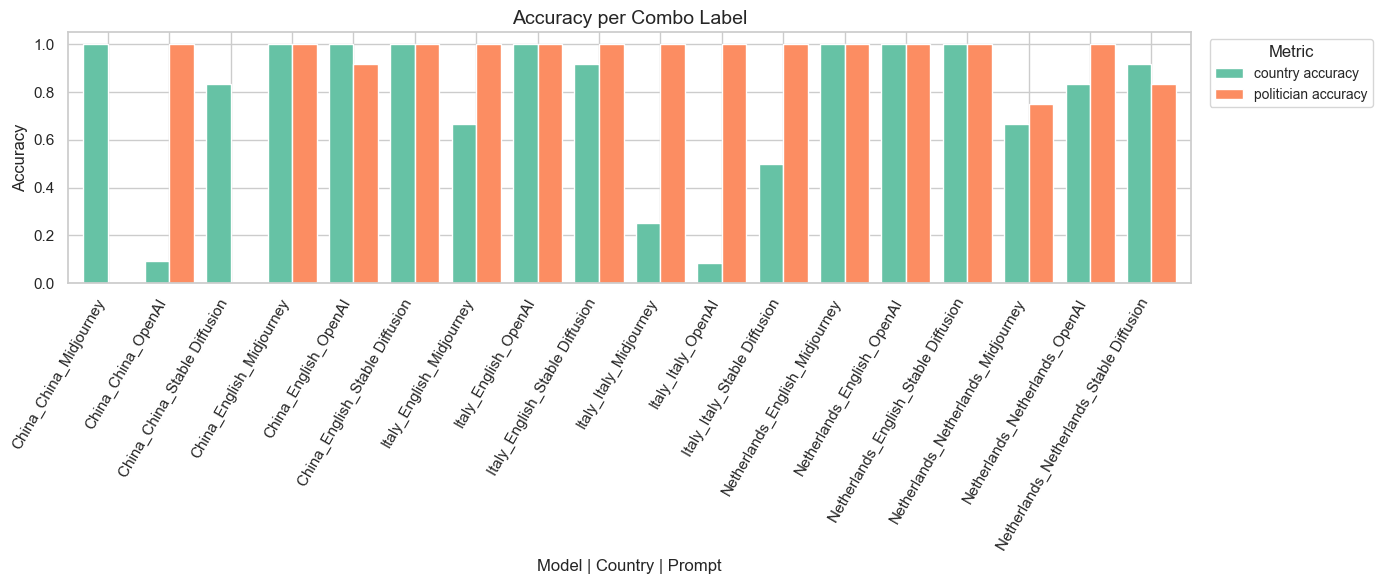

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and palette
sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")
acc_by_all = acc_by_all.rename(columns={"country_correct": "country accuracy", "politician": "politician accuracy"})
# Sort the data
#acc_sorted = acc_by_all.sort_values(by="country accuracy")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot with correct alignment
acc_by_all.plot(
    kind="bar",
    x="combo_label",
    ax=ax,
    color=custom_palette,
    width=0.8
)

# Fix label alignment
ax.set_xticks(range(len(acc_by_all)))
ax.set_xticklabels(acc_by_all["combo_label"], rotation=60, ha="right")

# Axis labels and title
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xlabel("Model | Country | Prompt", fontsize=12)
ax.set_title("Accuracy per Combo Label", fontsize=14)

# Legend outside
ax.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [62]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def reduce_embeddings(df, method='umap'):
    image_embs = np.stack(df['clip'].values)
    reducer = {
        'umap': umap.UMAP(metric="cosine", random_state=5),
        'tsne': TSNE(n_components=2, random_state=42),
        'pca': PCA(n_components=2)
    }[method]

    reduced = reducer.fit_transform(image_embs)
    df['x'] = reduced[:, 0]
    df['y'] = reduced[:, 1]
    return df

In [65]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np
import matplotlib.patches as mpatches

def plot_embeddings_with_double_borders(df, figsize=(20, 15), dot_size=100):
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in df.iterrows():
        x, y = row['x'], row['y']
        img_path = row['image_path']
        country_correct = row.get('country_correct', True)
        politician_correct = row.get('politician', True)

        # Define colors
        inner_color = 'green' if country_correct else 'red'
        outer_color = 'blue' if politician_correct else 'orange'

        try:
            img = Image.open(img_path)
            img.thumbnail((50, 50))
            imagebox = OffsetImage(img, zoom=1)

            # Outer box (politician) - slightly bigger
            outer_ab = AnnotationBbox(
                imagebox, (x, y),
                bboxprops=dict(edgecolor=outer_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(outer_ab)

            # Inner box (country) - on top, slightly smaller image
            inner_img = img.copy()
            inner_img.thumbnail((40, 40))
            inner_imagebox = OffsetImage(inner_img, zoom=1)
            inner_ab = AnnotationBbox(
                inner_imagebox, (x, y),
                bboxprops=dict(edgecolor=inner_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(inner_ab)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    # Optional: base scatter just for layout reference
    ax.scatter(df['x'], df['y'],
               c=df['country'].astype('category').cat.codes,
               cmap='tab20', alpha=0.05, s=dot_size)

    # Legend
    legend_elements = [
        mpatches.Patch(color='green', label='Country correct'),
        mpatches.Patch(color='red', label='Country wrong'),
        mpatches.Patch(color='blue', label='Politician correct'),
        mpatches.Patch(color='orange', label='Politician wrong'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    ax.set_title('UMAP of CLIP Embedding Space – Highlighting Country & Politician Accuracy', fontsize=16)
    #ax.axis('off')
    plt.tight_layout()
    plt.show()

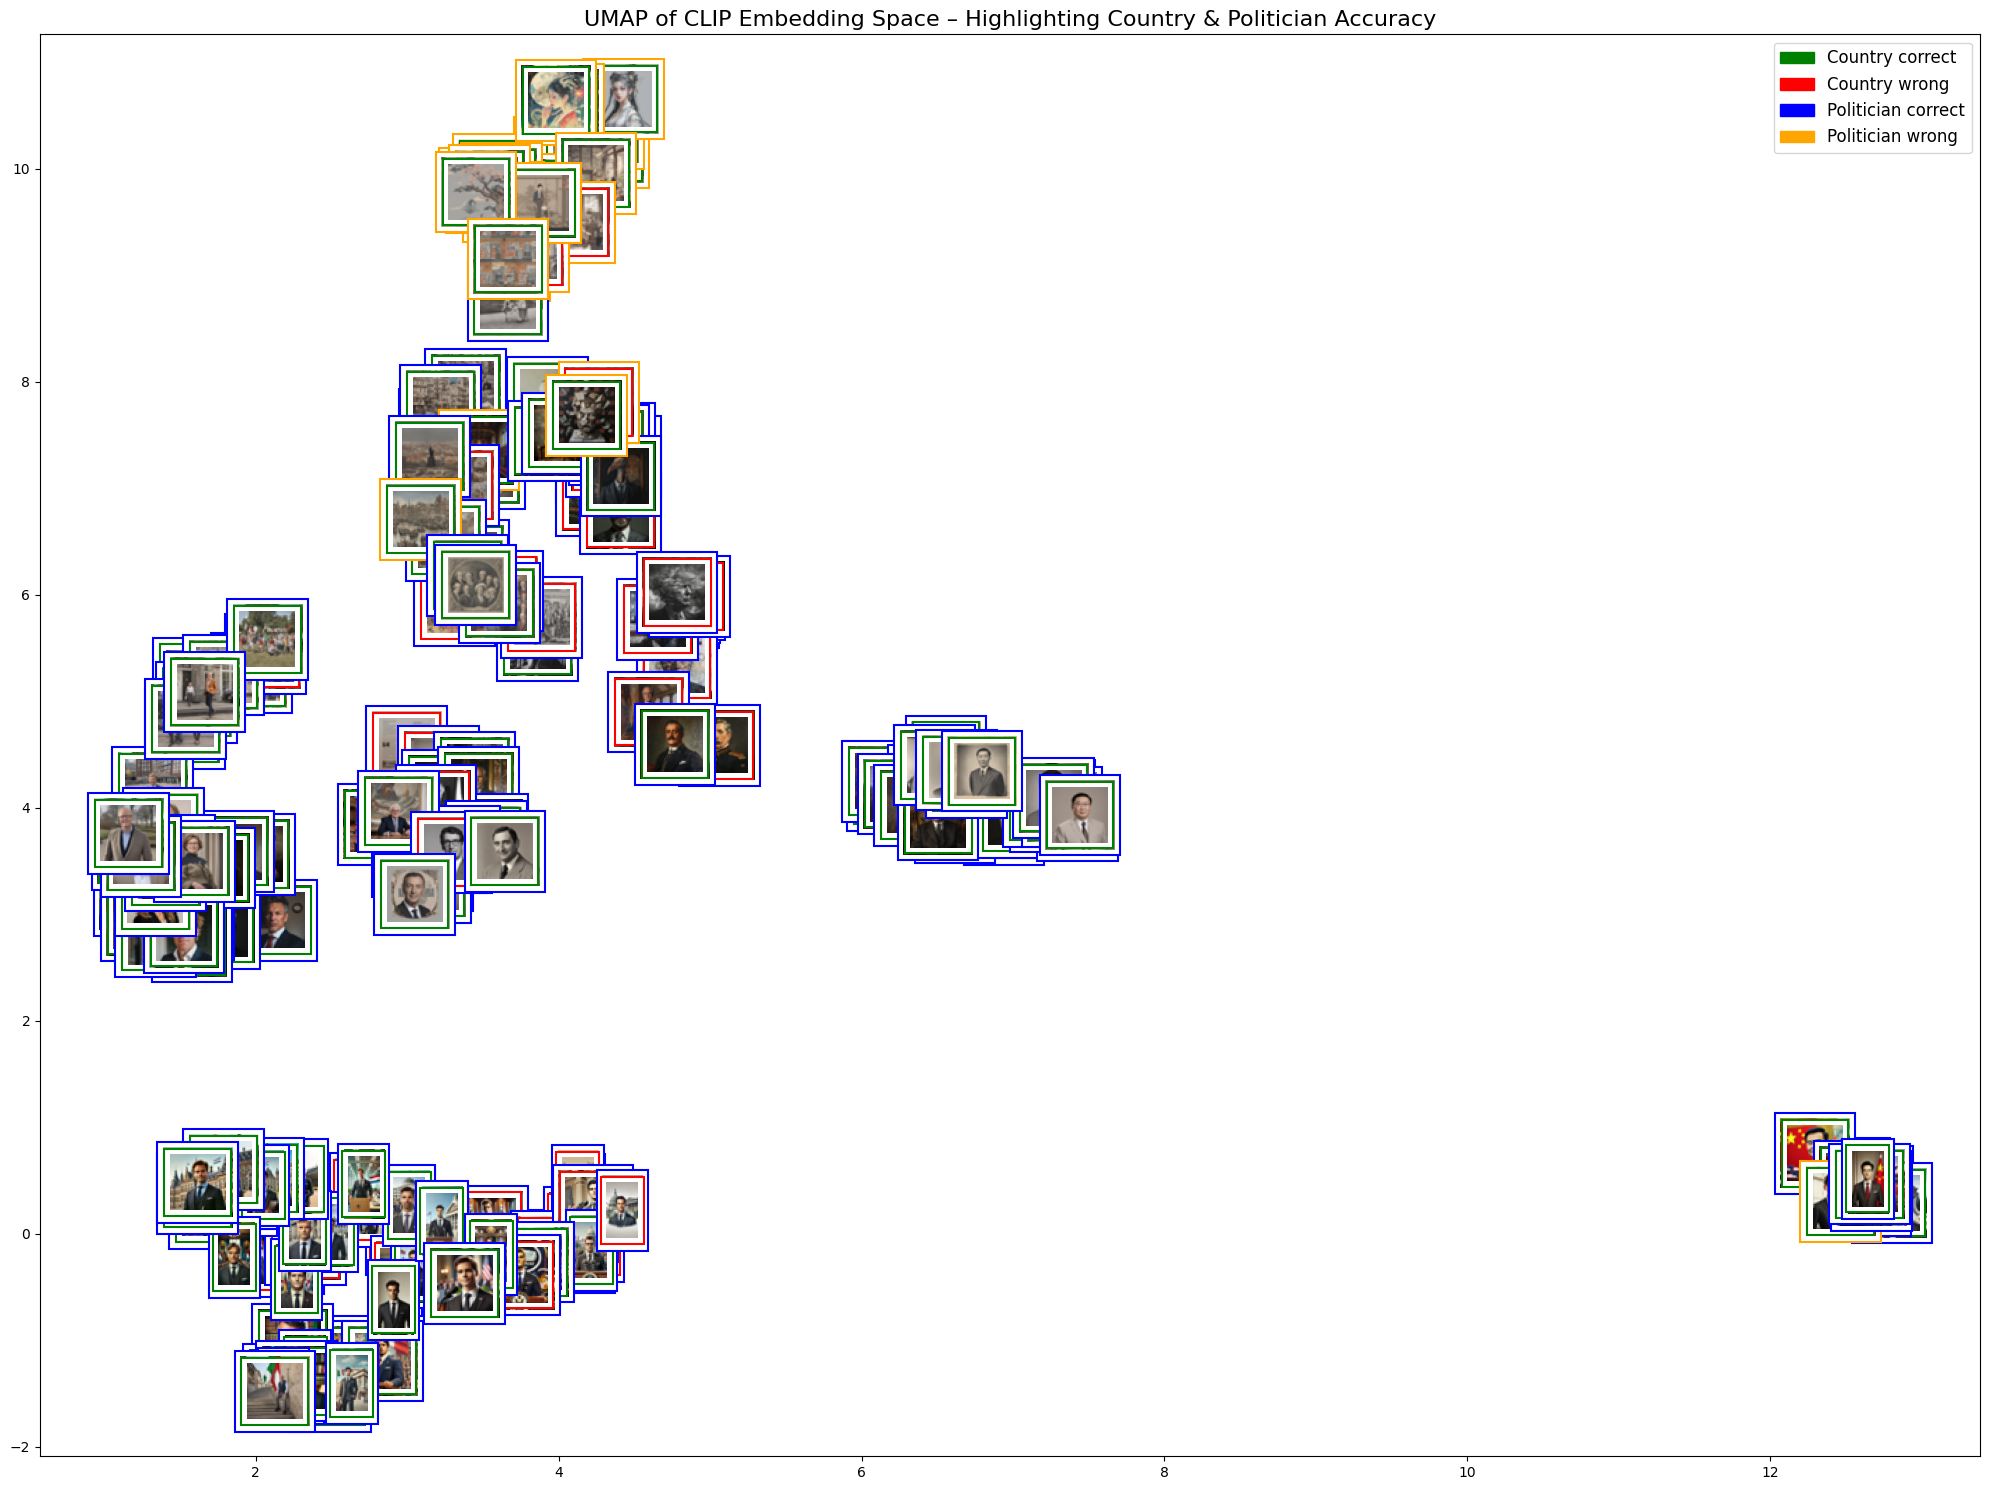

In [66]:
#df = reduce_embeddings(df, method='umap')
plot_embeddings_with_double_borders(df)

In [56]:
from sklearn.metrics import silhouette_score
import numpy as np

X = np.vstack(df["clip"].values)  # shape (n_samples, n_features)

# For each grouping, encode labels numerically
from sklearn.preprocessing import LabelEncoder

def silhouette_by_label(col_name):
    labels = LabelEncoder().fit_transform(df[col_name])
    score = silhouette_score(X, labels, metric='cosine')  # cosine distance fits CLIP
    print(f"Silhouette score for {col_name}: {score:.4f}")
    return score

silhouette_by_label("country")
silhouette_by_label("prompt")
silhouette_by_label("model")
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_by_label("combo_label")


Silhouette score for country: 0.0835
Silhouette score for prompt: 0.0705
Silhouette score for model: 0.1422
Silhouette score for combo_label: 0.1303


np.float64(0.13033862389761983)

In [57]:
df

,country,prompt,model,image_path,clip,predicted_country,country_correct,predicted_label,politician,x,y,combo_label
0,China,English,Midjourney,China/Prompt - English/Midjourney/8.png,"[-0.40805959700000005, -0.2398177981, -0.04937...",China,True,Photo of a politician,True,0.631498,4.640265,China_English_Midjourney
1,China,English,Midjourney,China/Prompt - English/Midjourney/9.png,"[0.0986498594, 0.0657103658, -0.2682773471, 0....",China,True,Photo of a politician,True,-2.496939,4.518386,China_English_Midjourney
2,China,English,Midjourney,China/Prompt - English/Midjourney/12.png,"[0.1768075824, 0.2613863945, 0.1217236221, -0....",China,True,Photo of a politician,True,-1.952812,4.060161,China_English_Midjourney
3,China,English,Midjourney,China/Prompt - English/Midjourney/11.png,"[0.09749138360000001, 0.1467541158, -0.3115982...",China,True,Photo of a politician,True,-1.661098,4.304735,China_English_Midjourney
4,China,English,Midjourney,China/Prompt - English/Midjourney/10.png,"[-0.5533872247, -0.016673140200000002, -0.2164...",China,True,Photo of a politician,True,-1.941592,4.190295,China_English_Midjourney
...,...,...,...,...,...,...,...,...,...,...,...,...
210,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.4226559997, -0.0634067953, -0.2045944929, -...",Netherlands,True,Photo of a politician,True,0.139197,7.704353,Netherlands_English_Stable Diffusion
211,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.5512455702, -0.2293194979, -0.1325238794000...",Netherlands,True,Photo of a politician,True,1.653440,6.720922,Netherlands_English_Stable Diffusion
212,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.0907077268, -0.2957334518, -0.5230876207, -...",Netherlands,True,Photo of a politician,True,0.209352,7.809371,Netherlands_English_Stable Diffusion
213,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.3316869438, 0.1016330421, -0.0122268572, -0...",Netherlands,True,Photo of a politician,True,1.623345,6.901073,Netherlands_English_Stable Diffusion


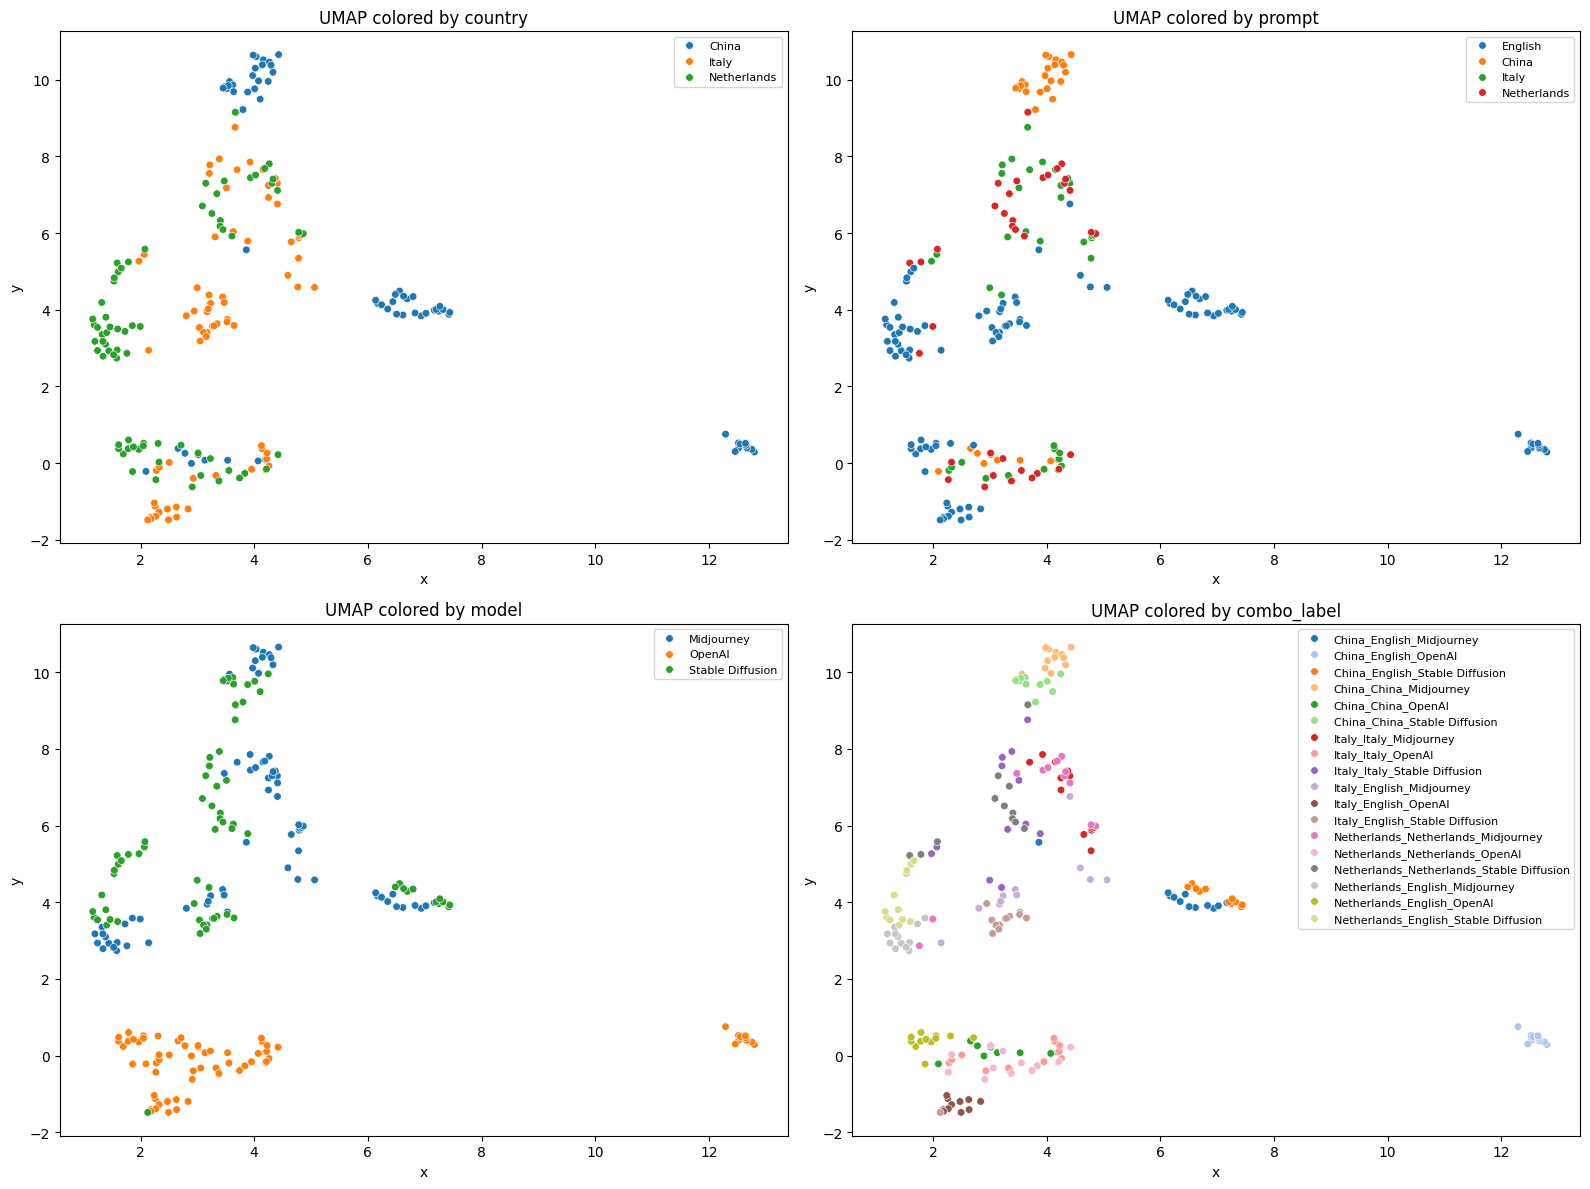

In [67]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns



# Visualize by country, prompt, model, or combo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    if col == "combo_label":
        sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab20", s=30)
    else:
        sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab10", s=30)
    ax.set_title(f"UMAP colored by {col}")
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    label_names = le.inverse_transform(np.unique(labels))

    # Get silhouette scores for each sample
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    # Add to dataframe for aggregation
    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)

    print(f"\n📊 Average silhouette scores per '{label_col}' value:\n")
    print(avg_scores)

    return avg_scores, df_sil

In [29]:
# Score per country
silhouette_scores_per_value(df, "country")

# Score per prompt
silhouette_scores_per_value(df, "prompt")

# Score per model
silhouette_scores_per_value(df, "model")

# Score per combo of all three
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_scores_per_value(df, "combo_label")


📊 Average silhouette scores per 'country' value:

country
China          0.134307
Italy          0.073296
Netherlands    0.043675
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'prompt' value:

prompt
China          0.141555
English        0.100172
Italy          0.030019
Netherlands   -0.047269
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'model' value:

model
OpenAI              0.355552
Midjourney          0.056796
Stable Diffusion    0.017306
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'combo_label' value:

combo_label
China_English_OpenAI                        0.494738
China_English_Stable Diffusion              0.403109
Italy_English_OpenAI                        0.337727
Netherlands_English_OpenAI                  0.256935
China_China_Midjourney                      0.248037
Netherlands_English_Midjourney              0.246562
Italy_English_Stable Diffusion              0.195369
China_China_Stable Diffusion         

(combo_label
 China_English_OpenAI                        0.494738
 China_English_Stable Diffusion              0.403109
 Italy_English_OpenAI                        0.337727
 Netherlands_English_OpenAI                  0.256935
 China_China_Midjourney                      0.248037
 Netherlands_English_Midjourney              0.246562
 Italy_English_Stable Diffusion              0.195369
 China_China_Stable Diffusion                0.146874
 Italy_Italy_Midjourney                      0.085855
 China_English_Midjourney                    0.059807
 Netherlands_English_Stable Diffusion        0.049832
 Netherlands_Netherlands_Stable Diffusion    0.015023
 China_China_OpenAI                          0.009647
 Italy_Italy_OpenAI                         -0.008481
 Italy_Italy_Stable Diffusion               -0.010775
 Italy_English_Midjourney                   -0.016537
 Netherlands_Netherlands_OpenAI             -0.080281
 Netherlands_Netherlands_Midjourney         -0.097402
 Name: silhouet

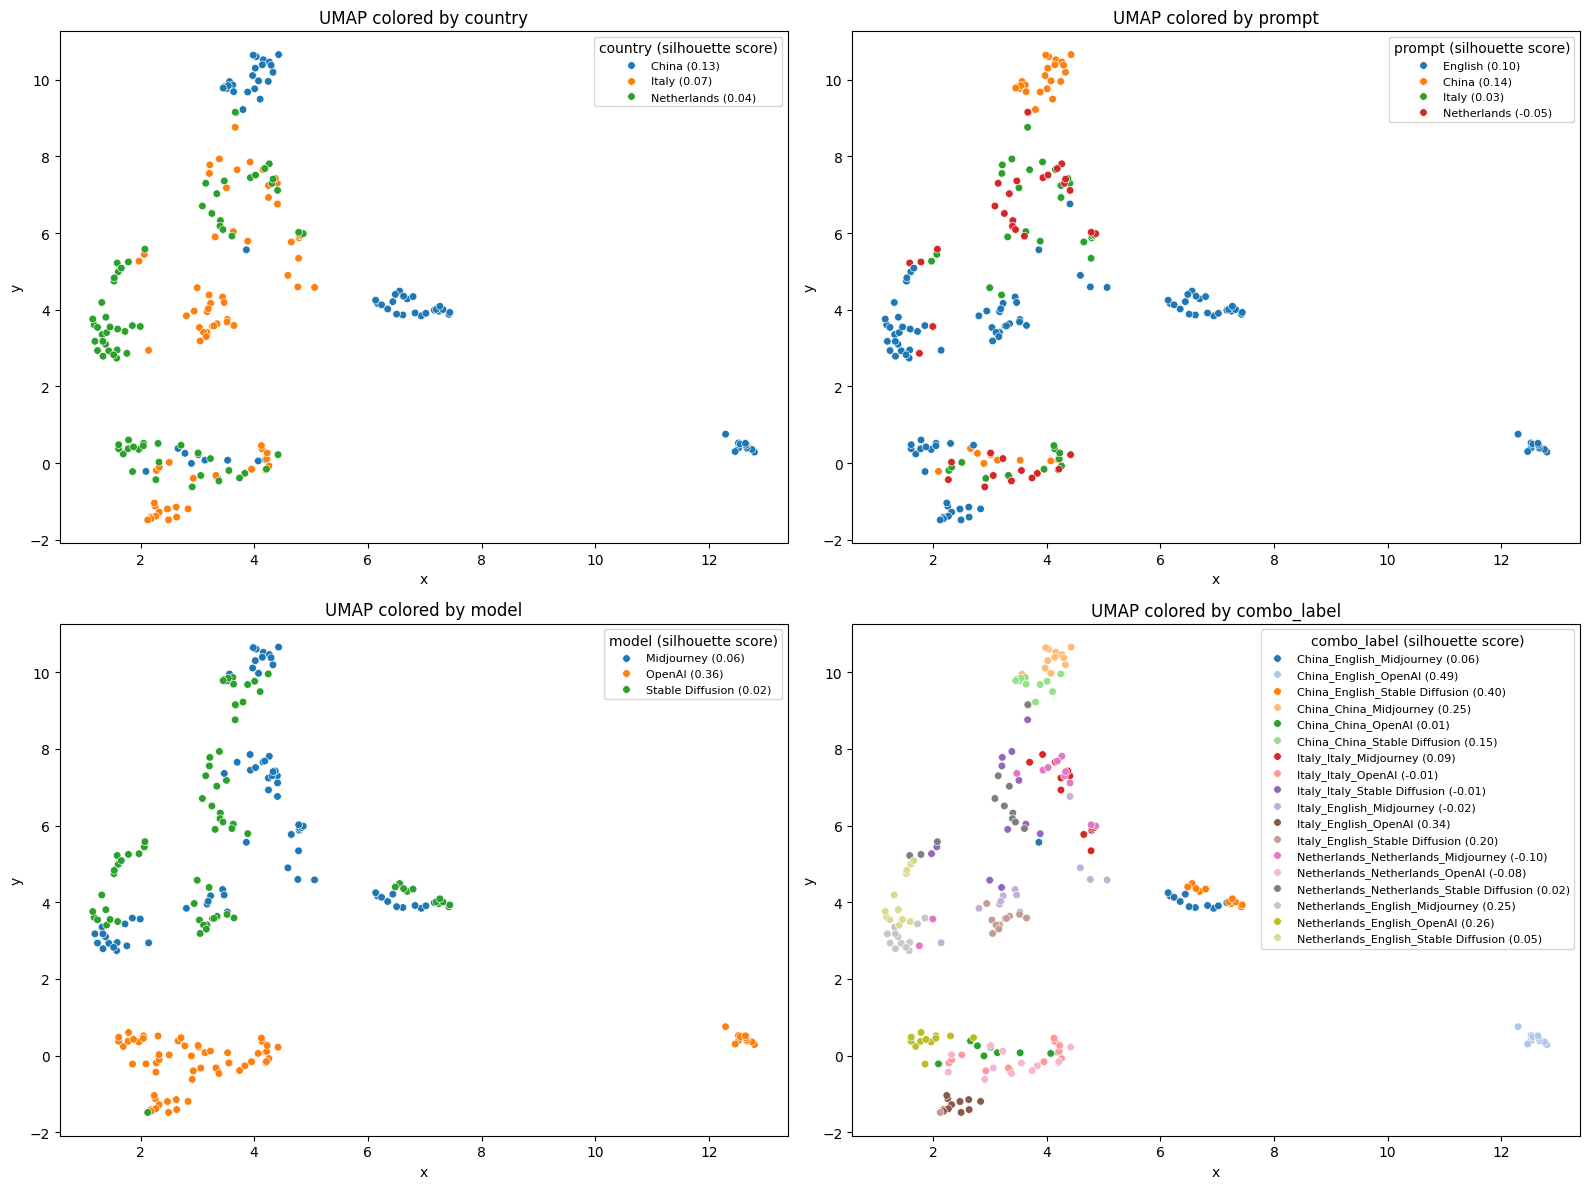

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)
    return avg_scores, df_sil

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    avg_scores, df_sil = silhouette_scores_per_value(df, col)

    # Create a mapping from original label to label with silhouette score
    score_map = {label: f"{label} ({score:.2f})" for label, score in avg_scores.items()}

    # Create a new column for the label with silhouette score for plotting
    df_sil[f"{col}_with_score"] = df_sil[col].map(score_map)

    # Choose palette
    palette = "tab20" if col == "combo_label" else "tab10"

    # Plot
    sns.scatterplot(data=df_sil, x="x", y="y", hue=f"{col}_with_score", ax=ax, palette=palette, s=30)
    ax.set_title(f"UMAP colored by {col}")
    ax.legend(loc="best", fontsize=8, title=f"{col} (silhouette score)")

plt.tight_layout()
plt.show()

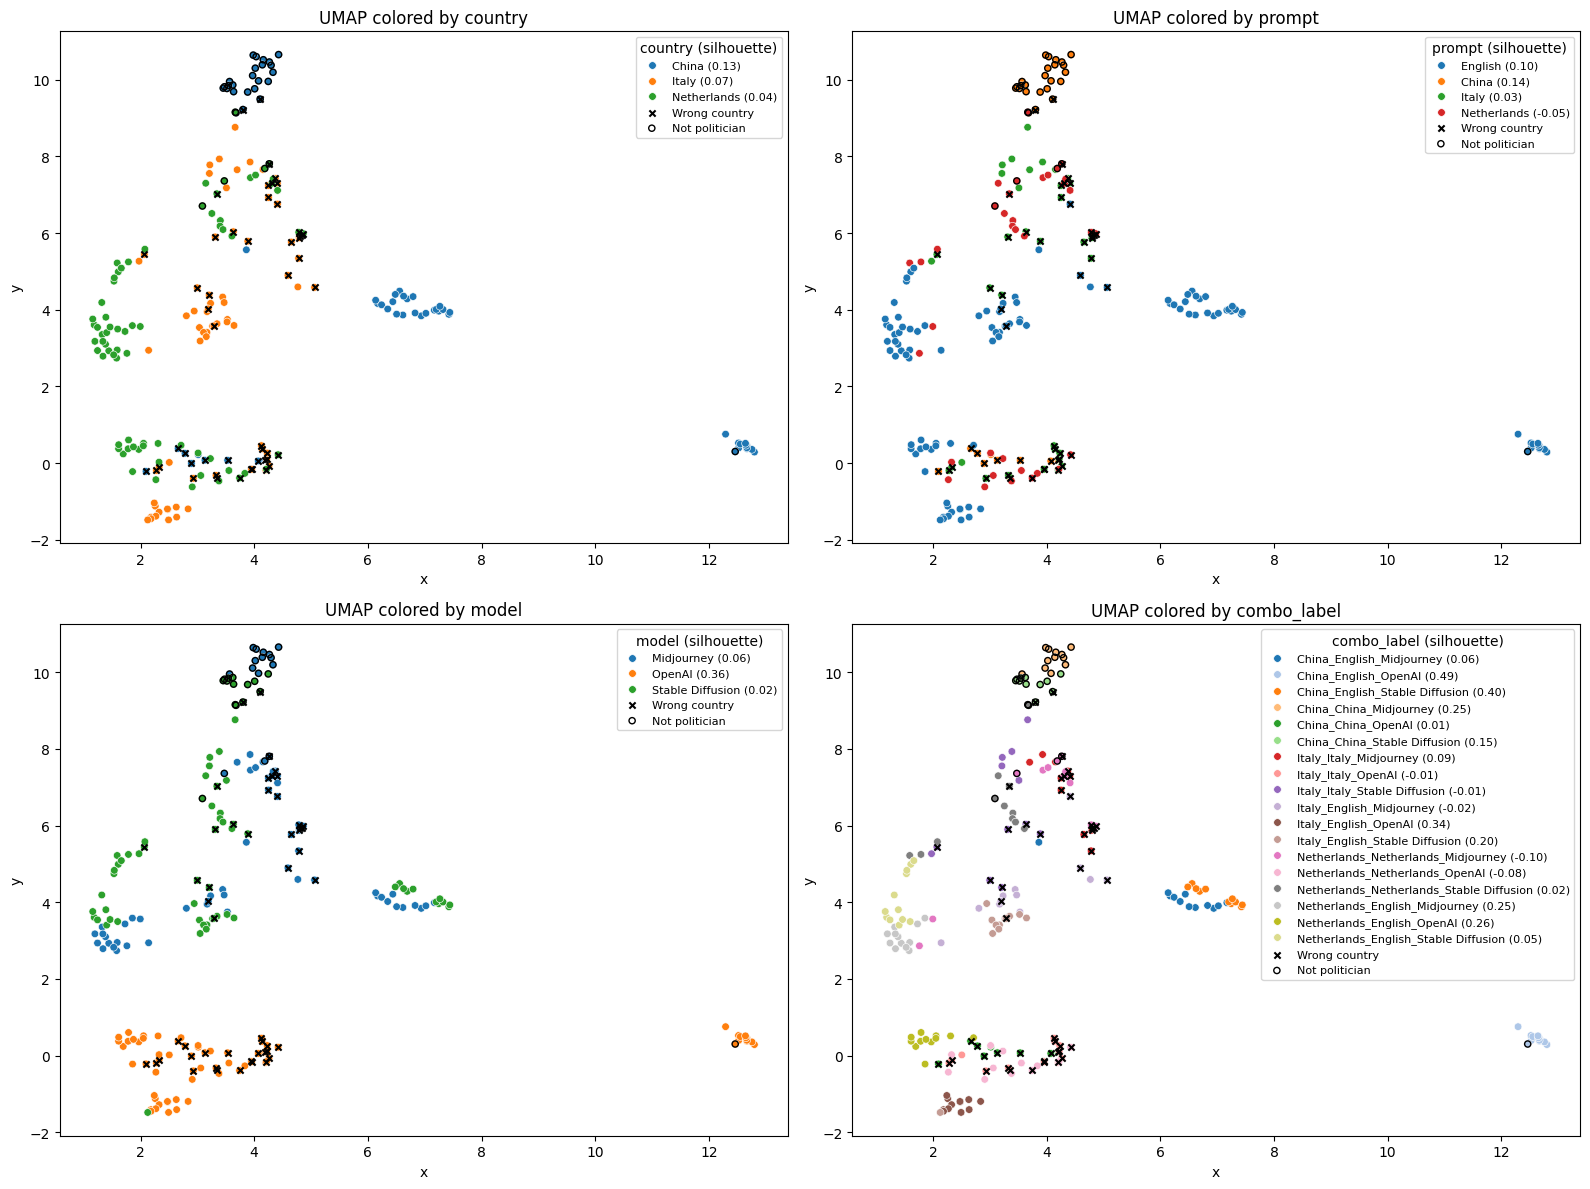

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.lines as mlines

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)
    return avg_scores, df_sil

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    avg_scores, df_sil = silhouette_scores_per_value(df, col)

    # Add silhouette score to labels
    score_map = {label: f"{label} ({score:.2f})" for label, score in avg_scores.items()}
    df_sil[f"{col}_with_score"] = df_sil[col].map(score_map)

    # Choose palette
    palette = "tab20" if col == "combo_label" else "tab10"

    # Main scatterplot
    sns.scatterplot(data=df_sil, x="x", y="y", hue=f"{col}_with_score", ax=ax, palette=palette, s=30, legend=True)

    # Overlay tiny black crosses for incorrect country
    wrong_country = df_sil[df_sil["country_correct"] == False]
    ax.scatter(wrong_country["x"], wrong_country["y"], color="black", marker="x", s=20, label="Wrong country")

    # Overlay tiny black circles for non-politicians
    not_politician = df_sil[df_sil["politician"] == False]
    ax.scatter(not_politician["x"], not_politician["y"], facecolors='none', edgecolors="black", marker="o", s=20, label="Not politician")

    # Title and legend
    ax.set_title(f"UMAP colored by {col}")

    # Build custom legend
    handles, labels = ax.get_legend_handles_labels()

    # Add marker legends manually if missing
    cross = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=11, label='Wrong country')
    circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=11, markerfacecolor='none', label='Not politician')

    # handles += [cross, circle]
    # labels += ['Wrong country', 'Not politician']

    ax.legend(handles=handles, labels=labels, loc="best", fontsize=8, title=f"{col} (silhouette)")

plt.tight_layout()
plt.show()

In [72]:
df

,country,prompt,model,image_path,clip,predicted_country,country_correct,predicted_label,politician,x,y,combo_label,umap_x,umap_y
0,China,English,Midjourney,China/Prompt - English/Midjourney/8.png,"[-0.40805959700000005, -0.2398177981, -0.04937...",China,True,Photo of a politician,True,3.862380,5.563287,China_English_Midjourney,3.862380,5.563287
1,China,English,Midjourney,China/Prompt - English/Midjourney/9.png,"[0.0986498594, 0.0657103658, -0.2682773471, 0....",China,True,Photo of a politician,True,6.939495,3.840424,China_English_Midjourney,6.939495,3.840424
2,China,English,Midjourney,China/Prompt - English/Midjourney/12.png,"[0.1768075824, 0.2613863945, 0.1217236221, -0....",China,True,Photo of a politician,True,6.171901,4.163507,China_English_Midjourney,6.171901,4.163507
3,China,English,Midjourney,China/Prompt - English/Midjourney/11.png,"[0.09749138360000001, 0.1467541158, -0.3115982...",China,True,Photo of a politician,True,6.137473,4.247863,China_English_Midjourney,6.137473,4.247863
4,China,English,Midjourney,China/Prompt - English/Midjourney/10.png,"[-0.5533872247, -0.016673140200000002, -0.2164...",China,True,Photo of a politician,True,6.439381,4.210258,China_English_Midjourney,6.439381,4.210258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.4226559997, -0.0634067953, -0.2045944929, -...",Netherlands,True,Photo of a politician,True,1.243463,3.539992,Netherlands_English_Stable Diffusion,1.243463,3.539992
211,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.5512455702, -0.2293194979, -0.1325238794000...",Netherlands,True,Photo of a politician,True,1.608669,4.988569,Netherlands_English_Stable Diffusion,1.608669,4.988569
212,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.0907077268, -0.2957334518, -0.5230876207, -...",Netherlands,True,Photo of a politician,True,1.159329,3.757754,Netherlands_English_Stable Diffusion,1.159329,3.757754
213,Netherlands,English,Stable Diffusion,Netherlands/Prompts - English/Stable Diffusion...,"[0.3316869438, 0.1016330421, -0.0122268572, -0...",Netherlands,True,Photo of a politician,True,1.538917,4.831561,Netherlands_English_Stable Diffusion,1.538917,4.831561
